Set up de la session spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StarClassification") \
    .config("spark.jars", "./mysql-connector-java-8.0.29.jar") \
    .enableHiveSupport() \
    .getOrCreate()

Configuration de la connexion JDBC

In [2]:
jdbc_url = "jdbc:mysql://mysql:3306/stardb"
properties = {
    "user": "root",
    "password": "rootpassword",
    "driver": "com.mysql.cj.jdbc.Driver"
}
data = spark.read.jdbc(url=jdbc_url, table="star_data", properties=properties)

Import

In [47]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import numpy as np

Remplacement des chaines de charactères

In [4]:
data = data.withColumn("class", when(data["class"] == "GALAXY", 0)
                                  .when(data["class"] == "QSO", 1)
                                  .when(data["class"] == "STAR", 2)
                                  .otherwise(-1))  # Valeur par défaut en cas de non correspondance

In [5]:
data.show()

+-------------------+-------+---------+-------+-------+-------+-------+-------+------+---------+-------+--------+-------------------+-----+-----------+-----+-----+--------+
|             obj_ID|  alpha|    delta|      u|      g|      r|      i|      z|run_ID|rereun_ID|cam_col|field_ID|        spec_obj_ID|class|   redshift|plate|  MJD|fiber_ID|
+-------------------+-------+---------+-------+-------+-------+-------+-------+------+---------+-------+--------+-------------------+-----+-----------+-----+-----+--------+
|1237645942904389888|54.5558| 0.223247|22.1987|19.8468|18.3741|17.1248|16.4361|   109|      301|      4|     133|1708153485381363712|    2|-1.07784E-4| 1517|52934|     594|
|1237645942904455168|54.6834| 0.216919|20.7986|19.5418|19.0461|18.8274|18.7466|   109|      301|      4|     134|3553453710967414784|    2|-6.27533E-5| 3156|54792|     413|
|1237645942905438464|57.0471|0.0843043|19.4687|18.1826|17.5906|17.2644|16.9529|   109|      301|      4|     149|1721601612033583104|  

Sélection des colonnes et nettoyage des données

In [6]:
selected_data = data.select("alpha", "delta", "u", "g", "r", "i", "z", "class", "redshift")
cleaned_data = selected_data.dropna()  # Remove rows with missing values
cleaned_data.show()

+-------+---------+-------+-------+-------+-------+-------+-----+-----------+
|  alpha|    delta|      u|      g|      r|      i|      z|class|   redshift|
+-------+---------+-------+-------+-------+-------+-------+-----+-----------+
|54.5558| 0.223247|22.1987|19.8468|18.3741|17.1248|16.4361|    2|-1.07784E-4|
|54.6834| 0.216919|20.7986|19.5418|19.0461|18.8274|18.7466|    2|-6.27533E-5|
|57.0471|0.0843043|19.4687|18.1826|17.5906|17.2644|16.9529|    0|  0.0361674|
|57.4884|0.0755838|22.9423|20.5669|19.3359| 18.776| 18.316|    0|   0.133383|
|57.4289|0.0730675|22.0245| 20.925|19.7406|19.2393|18.8451|    0|   0.361637|
|57.5096|0.0671615|21.9029|19.4385|18.0933|17.6189|17.0603|    0|   0.130619|
|57.5989| 0.063617|22.8123|21.4899|20.0463|19.5955|18.9974|    0|   0.241813|
|58.0384| 0.117742|22.4425|20.9633|20.0025| 19.471|19.3854|    0|   0.235817|
| 58.321| 0.145993|23.1723|20.5783|19.1496| 18.554|18.1542|    2| -5.4921E-5|
|58.3552|0.0795489|24.5039|21.8972|21.1263|20.7946|20.3679|    1

Vector assembler

In [7]:
feature_columns = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

Création du Random Forrest et de la regression linéaire

In [8]:
rf = RandomForestClassifier(labelCol="class", featuresCol="features")
lr = LogisticRegression(labelCol="class", featuresCol="features")

Création des pipelines

In [9]:
pipeline_rf = Pipeline(stages=[assembler, rf])
pipeline_lr = Pipeline(stages=[assembler, lr])

Séparation des données en données de test et de sets

In [10]:
train_data, test_data = cleaned_data.randomSplit([0.8, 0.2], seed=42)

Entrainement des données

In [11]:
model_rf = pipeline_rf.fit(train_data)
model_lr = pipeline_lr.fit(train_data)

Prédictions

In [25]:
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)

Evaluation

In [ ]:
Calculer la matrice de confusion RF

In [31]:
evaluator_rf_acc = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator.evaluate(predictions_rf)
evaluator_rf_f1 = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="f1")
f1_rf_score = evaluator_f1.evaluate(predictions_rf)
confusion_matrix = predictions_rf.groupBy("class", "prediction").count()
confusion_matrix.show()
print(f"F1 RF Score: {f1_rf_score:.2f}")
print(f"Accuracy RF: {accuracy_rf:.2f}")

+-----+----------+-----+
|class|prediction|count|
+-----+----------+-----+
|    1|       0.0|  430|
|    0|       2.0|  176|
|    0|       0.0| 9619|
|    1|       2.0|    3|
|    2|       2.0| 3486|
|    1|       1.0| 2496|
|    2|       0.0|    2|
|    0|       1.0|   97|
+-----+----------+-----+

F1 RF Score: 0.96
Accuracy RF: 0.96


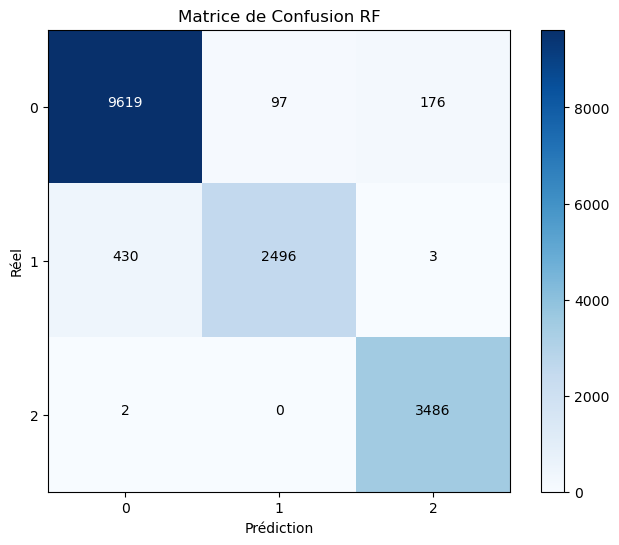

In [35]:
#On dessine la matrice de confusion RF
data = [(1, 0.0, 430),
        (0, 2.0, 176),
        (0, 0.0, 9619),
        (1, 2.0, 3),
        (2, 2.0, 3486),
        (1, 1.0, 2496),
        (2, 0.0, 2),
        (0, 1.0, 97)]

df = pd.DataFrame(data, columns=["TrueClass", "PredictedClass", "Count"])

confusion_matrix = df.pivot(index="TrueClass", columns="PredictedClass", values="Count").fillna(0)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion RF")
plt.colorbar()
classes = [0, 1, 2] 
tick_marks = [0, 1, 2]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, int(confusion_matrix.iloc[i, j]), horizontalalignment="center", color="white" if confusion_matrix.iloc[i, j] > confusion_matrix.values.max() / 2 else "black")

plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

Calculer la matrice de confusion LR

In [32]:
#Evaluation de notre modele regression logistique
evaluator_lr_acc = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
#Calcule de la precision
accuracy_lr = evaluator.evaluate(predictions_lr)
#Calcule score F1
evaluator_rf_f1 = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="f1")
f1_lr_score = evaluator_f1.evaluate(predictions_lr)
confusion_matrix = predictions_lr.groupBy("class", "prediction").count()
confusion_matrix.show()
print(f"F1 LR Score: {f1_lr_score:.2f}")
print(f"Accuracy LR: {accuracy_lr:.2f}")

+-----+----------+-----+
|class|prediction|count|
+-----+----------+-----+
|    1|       0.0|  398|
|    0|       2.0|  104|
|    0|       0.0| 9640|
|    1|       2.0|    1|
|    2|       2.0| 3488|
|    1|       1.0| 2530|
|    0|       1.0|  148|
+-----+----------+-----+

F1 LR Score: 0.96
Accuracy LR: 0.96


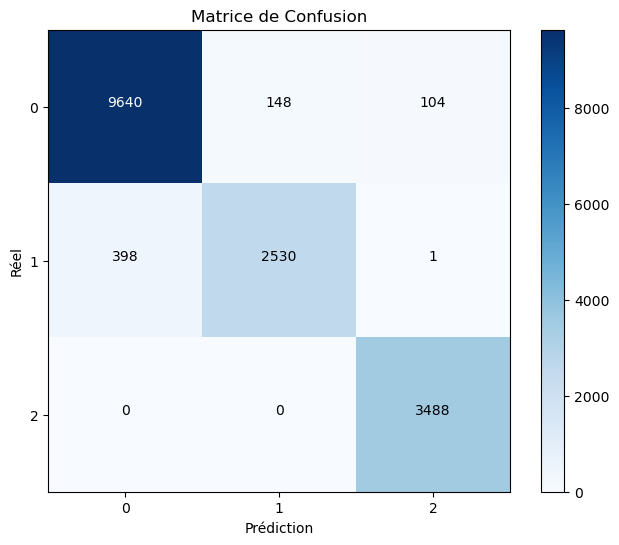

In [36]:
#On dessine la matrice de confusion LR
data = [(1, 0.0, 398),
        (0, 2.0, 104),
        (0, 0.0, 9640),
        (1, 2.0, 1),
        (2, 2.0, 3488),
        (1, 1.0, 2530),
        (0, 1.0, 148)]

df = pd.DataFrame(data, columns=["TrueClass", "PredictedClass", "Count"])

confusion_matrix = df.pivot(index="TrueClass", columns="PredictedClass", values="Count").fillna(0)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion LR")
plt.colorbar()
classes = [0, 1, 2] 
tick_marks = [0, 1, 2]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, int(confusion_matrix.iloc[i, j]), horizontalalignment="center", color="white" if confusion_matrix.iloc[i, j] > confusion_matrix.values.max() / 2 else "black")

plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

In [ ]:
x_bins = 100
y_bins = 100

Create a grid for the heatmap
# On cree une matrice pour la heatmap
def create_heatmap(data, x_bins, y_bins):
    heatmap_data = data.select("alpha", "delta").rdd.map(lambda x: (x[0], x[1]))
    heatmap, xedges, yedges = np.histogram2d(heatmap_data.collect(), bins=(x_bins, y_bins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    return heatmap.T, extent

# On cree la grille
heatmap, extent = create_heatmap(predictions, x_bins, y_bins)

# On plot la heatmap
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, extent=extent, origin="lower", cmap="inferno", aspect="auto")
plt.colorbar(label="Object Density")
plt.xlabel("Right Ascension (alpha)")
plt.ylabel("Declination (delta)")
plt.title("Astronomical Object Density Heatmap")
plt.show()
